In [ ]:
!pip install datasets
!pip install transformers
!pip install sentencepiece  

In [2]:
import numpy as np
import os
import random
import regex as re
import logging
import gc
from tqdm import tqdm, trange
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, classification_report
from datasets import load_dataset
import torch
import torch.nn as nn
from transformers import AdamW, get_linear_schedule_with_warmup
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset
from transformers import XLMRobertaTokenizer
from transformers.models.xlm_roberta.modeling_xlm_roberta import  XLMRobertaModel, XLMRobertaConfig
from transformers import BertConfig, BertTokenizer, BertModel
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')

In [3]:
dataset = load_dataset('persiannlp/parsinlu_entailment')

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/755 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1675 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/270 [00:00<?, ? examples/s]

Dataset parsinlu_reading_comprehension downloaded and prepared to /root/.cache/huggingface/datasets/persiannlp___parsinlu_reading_comprehension/parsinlu-repo/1.0.0/a99ad431d1637751f03fa9da3de66a41e93983d11116a0918a6efaaa72343d2d. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

{'c': 0.2718832891246684,
 'e': 0.40318302387267907,
 'n': 0.3249336870026525,
 'xx': 0.001326259946949602}

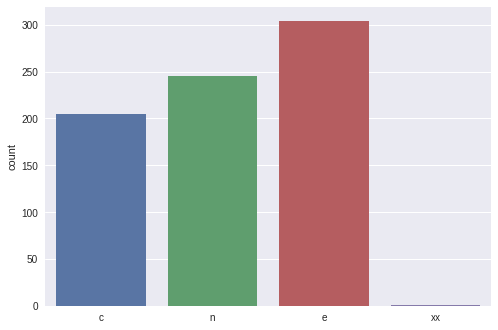

In [4]:
freq_dict = dict()
for data in dataset['train']:
    if (data['label'] in freq_dict): freq_dict[data['label']] += 1
    else: freq_dict[data['label']] = 1

for k,v in freq_dict.items():
    freq_dict[k] = v / (len(dataset['train']) - 1)

sns.countplot(x=dataset['train']['label'])
freq_dict

In [5]:
for data in dataset['train']:
    if(data['label'] == 'xx'): print(data)

{'sent1': 'xx', 'sent2': 'xx', 'category': 'natural-miras', 'label': 'xx'}


{'c': 0.40370370370370373, 'e': 0.28888888888888886, 'n': 0.3074074074074074}

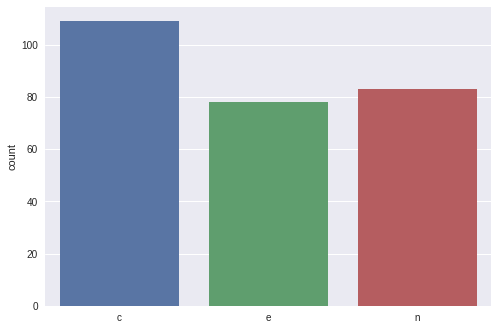

In [6]:
freq_dict = dict()
for data in dataset['validation']:
    if (data['label'] in freq_dict): freq_dict[data['label']] += 1
    else: freq_dict[data['label']] = 1

for k,v in freq_dict.items():
    freq_dict[k] = v / (len(dataset['validation']))

sns.countplot(x=dataset['validation']['label'])
freq_dict

{'-': 0.001195457262402869,
 'c': 0.3353257621040048,
 'e': 0.3646144650328751,
 'n': 0.30005977286312013}

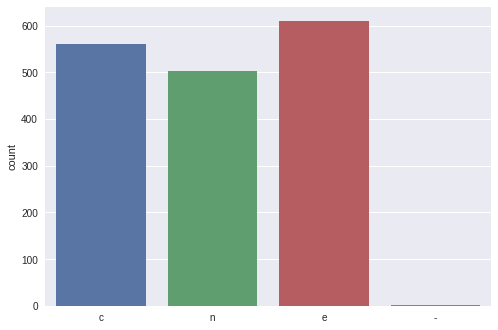

In [7]:
freq_dict = dict()
for data in dataset['test']:
    if (data['label'] in freq_dict): freq_dict[data['label']] += 1
    else: freq_dict[data['label']] = 1

for k,v in freq_dict.items():
    freq_dict[k] = v / (len(dataset['test']) - 2)

sns.countplot(x=dataset['test']['label'])
freq_dict

In [8]:
for data in dataset['test']:
    if(data['label'] == '-'): print(data)

{'sent1': 'آنها برنامه هایی را برای افزایش کارآیی و به کارگیری منابع به طور مؤثر تثبیت کردند', 'sent2': 'برنامه های افزایش بهره وری تلفیق شدند ، زیرا آنها عمیقاً به کارایی اهمیت می دهند.', 'category': 'translation-dev', 'label': '-'}
{'sent1': 'این هتل نوع جدیدی از هتل های فوق ستاره و کوچک را به نمایش می گذارد که فضای اداری عمومی را به افرادی که از راه دور کار میکنند, می فروشد.', 'sent2': 'افرادی که از راه دور کار میکنند  فضای اداری عمومی را خریداری می کند.', 'category': 'translation-dev', 'label': '-'}


In [9]:
class Textual_EntailementClassifier(nn.Module):
    def __init__(self, input_dim, num_labels=3, dropout_rate=0.):
        super(Textual_EntailementClassifier, self).__init__()
        self.dropout = nn.Dropout(dropout_rate)
        self.linear1 = nn.Linear(input_dim, input_dim // 3)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(input_dim // 3, num_labels)

    def forward(self, x):
        x = self.dropout(x)
        x = self.linear1(x)
        x = self.relu(x)
        return self.linear2(x)

In [10]:
class XLMRoBERTa_Textual_Entailement(BertModel):
    def __init__(self, config, args, label_lst):
        super(XLMRoBERTa_Textual_Entailement, self).__init__(config)
        self.args = args
        self.num_labels = len(set(label_lst))
        self.roberta = XLMRobertaModel(config=config) # Load pretrained Bert
        self.classifier = Textual_EntailementClassifier(config.hidden_size, self.num_labels, args.dropout_rate)

    def forward(self, input_ids, attention_mask, token_type_ids, label_ids):
        outputs = self.roberta(input_ids, attention_mask, token_type_ids)  # sequence_output, pooled_output, (hidden_states), (attentions)
        pooled_output = outputs[1]  # [CLS]
        label_logits = self.classifier(pooled_output)

        total_loss = 0
        # Softmax
        if label_ids is not None:
            loss = 0
            if self.num_labels == 1:
                loss_fct = nn.MSELoss()
                loss = loss_fct(label_logits.view(-1), label_ids.view(-1))
            else:
                loss_fct = nn.CrossEntropyLoss()
                loss = loss_fct(label_logits.view(-1, self.num_labels), label_ids.view(-1))
            total_loss += loss

        outputs = (label_logits,) + outputs[2:]  # add hidden states and attention if they are here
        outputs = (total_loss,) + outputs

        return outputs  # (loss), logits, (hidden_states), (attentions)

In [12]:
class ParsBERT_Textual_Entailement(BertModel):
    def __init__(self, config, args, label_lst):
        super(ParsBERT_Textual_Entailement, self).__init__(config)
        self.args = args
        self.num_labels = len(set(label_lst))
        self.parsbert = BertModel(config=config) # Load pretrained ParsBert
        self.classifier = Textual_EntailementClassifier(config.hidden_size, self.num_labels, args.dropout_rate)

    def forward(self, input_ids, attention_mask, token_type_ids, label_ids):
        outputs = self.parsbert(input_ids, attention_mask, token_type_ids)  # sequence_output, pooled_output, (hidden_states), (attentions)
        pooled_output = outputs[1]  # [CLS]
        label_logits = self.classifier(pooled_output)

        total_loss = 0
        # Softmax
        if label_ids is not None:
            loss = 0
            if self.num_labels == 1:
                loss_fct = nn.MSELoss()
                loss = loss_fct(label_logits.view(-1), label_ids.view(-1))
            else:
                loss_fct = nn.CrossEntropyLoss()
                loss = loss_fct(label_logits.view(-1, self.num_labels), label_ids.view(-1))
            total_loss += loss

        outputs = (label_logits,) + outputs[2:]  # add hidden states and attention if they are here
        outputs = (total_loss,) + outputs

        return outputs  # (loss), logits, (hidden_states), (attentions)

In [13]:
MODEL_CLASSES = {
    'XLMRoberta': (XLMRobertaConfig, XLMRoBERTa_Textual_Entailement, XLMRobertaTokenizer),
    'parsbert': (BertConfig, ParsBERT_Textual_Entailement, BertTokenizer),
}

MODEL_PATH_MAP = {
    'XLMRoberta': 'xlm-roberta-base',
    'parsbert': 'HooshvareLab/bert-fa-zwnj-base',
}

logger = logging.getLogger(__name__)

In [14]:
def load_tokenizer(args):
    return MODEL_CLASSES[args.model_type][2].from_pretrained(args.model_name_or_path)

def init_logger():
    logging.basicConfig(format='%(asctime)s - %(levelname)s - %(name)s -   %(message)s',
                        datefmt='%m/%d/%Y %H:%M:%S',
                        level=logging.INFO)
    
def label2index(label):
    if (label == 'e'): return 0
    elif (label == 'c'): return 1
    else: return 2

def get_labels(dataset):
  train_label = list()
  for data in dataset:
      if (data['label'] != 'xx' and data['label'] != '-'): train_label.append(data['label'])
  
  return train_label

def set_seed(args):
    random.seed(args.seed)
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)
    if not args.no_cuda and torch.cuda.is_available():
        torch.cuda.manual_seed_all(args.seed)

In [15]:
def prepare_dataset(data, args, tokenizer, padding='max_length'):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    all_label = torch.tensor([label2index(x['label']) for x in data if  (x['label'] != 'xx' and x['label'] != '-')], dtype=torch.long).to(device)
    bert_input = tokenizer([x['sent1'] for x in data if (x['label'] != 'xx' and x['label'] != '-')] , [x['sent2'] for x in data if (x['label'] != 'xx' and x['label'] != '-')], padding=padding, max_length=args.max_seq_len, truncation=True, return_tensors="pt")
    if ('token_type_ids' in bert_input):
        dataset = TensorDataset(bert_input['input_ids'].to(device), bert_input['attention_mask'].to(device), bert_input['token_type_ids'].to(device), all_label)
    else:
        dataset = TensorDataset(bert_input['input_ids'].to(device), bert_input['attention_mask'].to(device), torch.zeros_like(bert_input['input_ids']).to(device), all_label)

    return dataset

In [16]:
class Trainer(object):
    def __init__(self, args, train_dataset=None, dev_dataset=None, test_dataset=None):
        self.args = args
        self.train_dataset = train_dataset
        self.dev_dataset = dev_dataset
        self.test_dataset = test_dataset

        self.label_lst = get_labels(dataset['train'])

        self.config_class, self.model_class, _ = MODEL_CLASSES[args.model_type]
        self.config = self.config_class.from_pretrained(args.model_name_or_path, finetuning_task=args.task)
        self.model = self.model_class.from_pretrained(args.model_name_or_path,
                                                      config=self.config,
                                                      args=args,
                                                      label_lst=self.label_lst)
                                                      

        # GPU or CPU
        self.device = "cuda" if torch.cuda.is_available() and not args.no_cuda else "cpu"
        self.model.to(self.device)

    def train(self):
        train_sampler = RandomSampler(self.train_dataset)
        train_dataloader = DataLoader(self.train_dataset, sampler=train_sampler, batch_size=self.args.train_batch_size)
        if self.args.max_steps > 0:
            t_total = self.args.max_steps
            self.args.num_train_epochs = self.args.max_steps // (len(train_dataloader) // self.args.gradient_accumulation_steps) + 1
        else:
            t_total = len(train_dataloader) // self.args.gradient_accumulation_steps * self.args.num_train_epochs

        # Prepare optimizer and schedule (linear warmup and decay)
        no_decay = ['bias', 'LayerNorm.weight']
        optimizer_grouped_parameters = [
            {'params': [p for n, p in self.model.named_parameters() if not any(nd in n for nd in no_decay)],
             'weight_decay': self.args.weight_decay},
            {'params': [p for n, p in self.model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
        ]
        optimizer = AdamW(optimizer_grouped_parameters, lr=self.args.learning_rate, eps=self.args.adam_epsilon)
        scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=self.args.warmup_steps, num_training_steps=t_total)

        # Train!
        logger.info("***** Running training *****")
        logger.info("  Num examples = %d", len(self.train_dataset))
        logger.info("  Num Epochs = %d", self.args.num_train_epochs)
        logger.info("  Total train batch size = %d", self.args.train_batch_size)
        logger.info("  Gradient Accumulation steps = %d", self.args.gradient_accumulation_steps)
        logger.info("  Total optimization steps = %d", t_total)
        logger.info("  Logging steps = %d", self.args.logging_steps)
        logger.info("  Save steps = %d", self.args.save_steps)

        global_step = 0
        tr_loss = 0.0
        self.model.zero_grad()
        best_acc = -1
       
        train_iterator = trange(int(self.args.num_train_epochs), desc="Epoch")
        for _ in train_iterator:
            label_preds = None
            out_label_ids = None
            # epoch_iterator = tqdm(train_dataloader, desc="Iteration")
            for step, batch in enumerate(train_dataloader):
                self.model.train()
                inputs = {'input_ids': batch[0],
                          'attention_mask': batch[1],
                          'token_type_ids': batch[2],
                          'label_ids': batch[3]}
                outputs = self.model(**inputs)
                loss = outputs[0]
                label_logits = outputs[1]

                 # label prediction
                if label_preds is None:
                    label_preds = label_logits.detach().cpu().numpy()
                    out_label_ids = inputs['label_ids'].detach().cpu().numpy()
                else:
                    label_preds = np.append(label_preds, label_logits.detach().cpu().numpy(), axis=0)
                    out_label_ids = np.append(out_label_ids, inputs['label_ids'].detach().cpu().numpy(), axis=0)
                
                if self.args.gradient_accumulation_steps > 1:
                    loss = loss / self.args.gradient_accumulation_steps

                loss.backward()

                tr_loss += loss.item()
                if (step + 1) % self.args.gradient_accumulation_steps == 0:
                    torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.args.max_grad_norm)

                    optimizer.step()
                    scheduler.step()  # Update learning rate schedule
                    self.model.zero_grad()
                    global_step += 1

                    if(global_step % 10 == 0): logger.info("Train loss = %.4f", tr_loss / global_step)
                    if (self.args.logging_steps > 0 and global_step % self.args.logging_steps == 0):
                        results = self.evaluate("dev")
                        if (float(results['accuracy']) > best_acc):
                        # if (float(results['slot_f1']) > best_f1):
                        #   best_f1 = float(results['slot_f1'])
                          best_acc = float(results['accuracy'])
                          logger.info("dev best_acc = %.4f", best_acc * 100.0)
                          self.save_model()

                   
            if 0 < self.args.max_steps < global_step:
                train_iterator.close()
                break
            
            # label result
            label_preds = np.argmax(label_preds, axis=1)
            logger.info("train_acc = %.4f", accuracy_score(out_label_ids, label_preds) * 100.0)


        return global_step, tr_loss / global_step

    def evaluate(self, mode):
        if mode == 'test':
            dataset = self.test_dataset
        elif mode == 'dev':
            dataset = self.dev_dataset
        else:
            raise Exception("Only dev and test dataset available")

        eval_sampler = SequentialSampler(dataset)
        eval_dataloader = DataLoader(dataset, sampler=eval_sampler, batch_size=self.args.eval_batch_size)

        # Eval!
        logger.info("\n***** Running evaluation on %s dataset *****", mode)
        logger.info("  Num examples = %d", len(dataset))
        logger.info("  Batch size = %d", self.args.eval_batch_size)
        eval_loss = 0.0
        nb_eval_steps = 0
        label_preds = None
        out_label_ids = None

        self.model.eval()

        # for batch in tqdm(eval_dataloader, desc="Evaluating"):
        for batch in eval_dataloader:
            batch = tuple(t.to(self.device) for t in batch)
            with torch.no_grad():
                inputs = {'input_ids': batch[0],
                          'attention_mask': batch[1],
                          'token_type_ids': batch[2],
                          'label_ids': batch[3]}
                outputs = self.model(**inputs)
                tmp_eval_loss, label_logits = outputs[:2]
                eval_loss += tmp_eval_loss.mean().item()
            
            nb_eval_steps += 1

            # label prediction
            if label_preds is None:
                label_preds = label_logits.detach().cpu().numpy()
                out_label_ids = inputs['label_ids'].detach().cpu().numpy()
            else:
                label_preds = np.append(label_preds, label_logits.detach().cpu().numpy(), axis=0)
                out_label_ids = np.append(out_label_ids, inputs['label_ids'].detach().cpu().numpy(), axis=0)


        eval_loss = eval_loss / nb_eval_steps
        results = {
            "loss": eval_loss
        }

        # label result
        label_preds = np.argmax(label_preds, axis=1)
        print(set(label_preds))
        total_result = accuracy_score(out_label_ids, label_preds)
        results.update({'accuracy' : total_result})
        logger.info("***** Eval results *****")
        for key in sorted(results.keys()):
            logger.info("  %s = %.4f", key if key != 'loss' else 'loss', float(results[key]) * 100.0 if key != 'loss' else float(results[key]))

        if (mode == 'test'): print(classification_report(out_label_ids, label_preds, target_names=['e', 'c', 'n'], digits = 4))
        return results

    def save_model(self):
        # Save model checkpoint (Overwrite)
        if not os.path.exists(self.args.model_dir):
            os.makedirs(self.args.model_dir)
        model_to_save = self.model.module if hasattr(self.model, 'module') else self.model
        model_to_save.save_pretrained(self.args.model_dir)


    def load_model(self):
        # Check whether model exists
        if not os.path.exists(self.args.model_dir):
            raise Exception("Model doesn't exists! Train first!")

        try:
            self.model = self.model_class.from_pretrained(self.args.model_dir,
                                                          args=self.args,
                                                          label_lst=self.label_lst)
            self.model.to(self.device)
            logger.info("***** Model Loaded *****")
        except:
            raise Exception("Some model files might be missing...")


In [17]:
class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

Using XLMRoberta


In [18]:
args = dotdict(dict())
args.seed = 810197502 # to make results reproducible
args.model_type = 'XLMRoberta' 
args.model_name_or_path = MODEL_PATH_MAP[args.model_type]
args.dropout_rate =  0.3
args.do_train = True
args.do_eval = True
args.train_batch_size = 32 
args.max_steps = -1
args.task = 'Textual_Entailement' 
args.no_cuda = False
args.weight_decay = 0
args.num_train_epochs = 30
args.gradient_accumulation_steps = 1
args.learning_rate = 3e-5 
args.adam_epsilon = 1e-8
args.warmup_steps = 0 
args.logging_steps = 50
args.save_steps = 250
args.max_grad_norm = 1
args.eval_batch_size = 64
args.model_dir = "Textual_Entailement_model_" + args.model_type
args.max_seq_len = 128


In [ ]:
init_logger()
set_seed(args)
tokenizer = load_tokenizer(args)

In [ ]:
train_dataset = prepare_dataset(dataset['train'], args, tokenizer)
valid_dataset = prepare_dataset(dataset['validation'], args, tokenizer)
test_dataset = prepare_dataset(dataset['test'], args, tokenizer)

In [ ]:
trainer = Trainer(args, train_dataset, valid_dataset, test_dataset)

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRoBERTa_Textual_Entailement: ['lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing XLMRoBERTa_Textual_Entailement from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRoBERTa_Textual_Entailement from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRoBERTa_Textual_Entailement were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['encoder.layer.2.output.dense.weight', 'encoder.layer.10.attention.self.value.bias', 'encoder.lay

In [ ]:
gc.collect()
torch.cuda.empty_cache()

In [ ]:
if args.do_train:
    # trainer.load_model()
    trainer.train()

if args.do_eval:
    # trainer.load_model()
    trainer.evaluate("test")

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
05/24/2022 19:14:55 - INFO - __main__ -   ***** Running training *****
05/24/2022 19:14:55 - INFO - __main__ -     Num examples = 754
05/24/2022 19:14:55 - INFO - __main__ -     Num Epochs = 30
05/24/2022 19:14:55 - INFO - __main__ -     Total train batch size = 32
05/24/2022 19:14:55 - INFO - __main__ -     Gradient Accumulation steps = 1
05/24/2022 19:14:55 - INFO - __main__ -     Total optimization steps = 720
05/24/2022 19:14:55 - INFO - __main__ -     Logging steps = 50
05/24/2022 19:14:55 - INFO - __main__ -     Save steps = 250
Epoch:   0%|          | 0/30 [00:00<?, ?it/s]05/24/2022 19:15:02 - INFO - __main__ -   Train loss = 1.0926
05/24/2022 19:15:10 - INFO - __main__ -   Tr

{0}


05/24/2022 19:15:50 - INFO - __main__ -   Train loss = 1.0924
05/24/2022 19:15:58 - INFO - __main__ -   Train loss = 1.0906
05/24/2022 19:15:59 - INFO - __main__ -   train_acc = 40.0531
Epoch:  10%|█         | 3/30 [01:03<10:12, 22.69s/it]05/24/2022 19:16:05 - INFO - __main__ -   Train loss = 1.0895
05/24/2022 19:16:12 - INFO - __main__ -   Train loss = 1.0896
05/24/2022 19:16:16 - INFO - __main__ -   train_acc = 40.3183
Epoch:  13%|█▎        | 4/30 [01:21<08:56, 20.64s/it]05/24/2022 19:16:19 - INFO - __main__ -   Train loss = 1.0896
05/24/2022 19:16:19 - INFO - __main__ -   
***** Running evaluation on dev dataset *****
05/24/2022 19:16:19 - INFO - __main__ -     Num examples = 270
05/24/2022 19:16:19 - INFO - __main__ -     Batch size = 64
05/24/2022 19:16:21 - INFO - __main__ -   ***** Eval results *****
05/24/2022 19:16:21 - INFO - __main__ -     accuracy = 28.8889
05/24/2022 19:16:21 - INFO - __main__ -     loss = 1.1287


{0}


05/24/2022 19:16:29 - INFO - __main__ -   Train loss = 1.0892
05/24/2022 19:16:36 - INFO - __main__ -   Train loss = 1.0883
05/24/2022 19:16:36 - INFO - __main__ -   train_acc = 40.4509
Epoch:  17%|█▋        | 5/30 [01:40<08:25, 20.23s/it]05/24/2022 19:16:43 - INFO - __main__ -   Train loss = 1.0873
05/24/2022 19:16:51 - INFO - __main__ -   Train loss = 1.0880
05/24/2022 19:16:53 - INFO - __main__ -   train_acc = 40.3183
Epoch:  20%|██        | 6/30 [01:58<07:42, 19.28s/it]05/24/2022 19:16:58 - INFO - __main__ -   Train loss = 1.0872
05/24/2022 19:16:58 - INFO - __main__ -   
***** Running evaluation on dev dataset *****
05/24/2022 19:16:58 - INFO - __main__ -     Num examples = 270
05/24/2022 19:16:58 - INFO - __main__ -     Batch size = 64
05/24/2022 19:17:00 - INFO - __main__ -   ***** Eval results *****
05/24/2022 19:17:00 - INFO - __main__ -     accuracy = 28.8889
05/24/2022 19:17:00 - INFO - __main__ -     loss = 1.1375


{0}


05/24/2022 19:17:07 - INFO - __main__ -   Train loss = 1.0882
05/24/2022 19:17:13 - INFO - __main__ -   train_acc = 40.3183
Epoch:  23%|██▎       | 7/30 [02:17<07:23, 19.26s/it]05/24/2022 19:17:14 - INFO - __main__ -   Train loss = 1.0877
05/24/2022 19:17:21 - INFO - __main__ -   Train loss = 1.0880
05/24/2022 19:17:29 - INFO - __main__ -   Train loss = 1.0880
05/24/2022 19:17:30 - INFO - __main__ -   train_acc = 40.3183
Epoch:  27%|██▋       | 8/30 [02:34<06:50, 18.68s/it]05/24/2022 19:17:36 - INFO - __main__ -   Train loss = 1.0871
05/24/2022 19:17:36 - INFO - __main__ -   
***** Running evaluation on dev dataset *****
05/24/2022 19:17:36 - INFO - __main__ -     Num examples = 270
05/24/2022 19:17:36 - INFO - __main__ -     Batch size = 64
05/24/2022 19:17:38 - INFO - __main__ -   ***** Eval results *****
05/24/2022 19:17:38 - INFO - __main__ -     accuracy = 28.8889
05/24/2022 19:17:38 - INFO - __main__ -     loss = 1.1328


{0}


05/24/2022 19:17:45 - INFO - __main__ -   Train loss = 1.0870
05/24/2022 19:17:49 - INFO - __main__ -   train_acc = 40.3183
Epoch:  30%|███       | 9/30 [02:54<06:36, 18.89s/it]05/24/2022 19:17:52 - INFO - __main__ -   Train loss = 1.0866
05/24/2022 19:18:00 - INFO - __main__ -   Train loss = 1.0871
05/24/2022 19:18:07 - INFO - __main__ -   Train loss = 1.0867
05/24/2022 19:18:07 - INFO - __main__ -   train_acc = 40.7162
Epoch:  33%|███▎      | 10/30 [03:11<06:09, 18.47s/it]05/24/2022 19:18:14 - INFO - __main__ -   Train loss = 1.0854
05/24/2022 19:18:14 - INFO - __main__ -   
***** Running evaluation on dev dataset *****
05/24/2022 19:18:14 - INFO - __main__ -     Num examples = 270
05/24/2022 19:18:14 - INFO - __main__ -     Batch size = 64
05/24/2022 19:18:16 - INFO - __main__ -   ***** Eval results *****
05/24/2022 19:18:16 - INFO - __main__ -     accuracy = 45.1852
05/24/2022 19:18:16 - INFO - __main__ -     loss = 1.1041
05/24/2022 19:18:16 - INFO - __main__ -   dev best_acc = 45

{0, 1, 2}


05/24/2022 19:18:33 - INFO - __main__ -   Train loss = 1.0839
05/24/2022 19:18:36 - INFO - __main__ -   train_acc = 44.2971
Epoch:  37%|███▋      | 11/30 [03:40<06:50, 21.58s/it]05/24/2022 19:18:40 - INFO - __main__ -   Train loss = 1.0823
05/24/2022 19:18:47 - INFO - __main__ -   Train loss = 1.0802
05/24/2022 19:18:53 - INFO - __main__ -   train_acc = 48.5411
Epoch:  40%|████      | 12/30 [03:58<06:06, 20.38s/it]05/24/2022 19:18:55 - INFO - __main__ -   Train loss = 1.0778
05/24/2022 19:19:02 - INFO - __main__ -   Train loss = 1.0738
05/24/2022 19:19:02 - INFO - __main__ -   
***** Running evaluation on dev dataset *****
05/24/2022 19:19:02 - INFO - __main__ -     Num examples = 270
05/24/2022 19:19:02 - INFO - __main__ -     Batch size = 64
05/24/2022 19:19:04 - INFO - __main__ -   ***** Eval results *****
05/24/2022 19:19:04 - INFO - __main__ -     accuracy = 45.5556
05/24/2022 19:19:04 - INFO - __main__ -     loss = 1.1035
05/24/2022 19:19:04 - INFO - __main__ -   dev best_acc = 4

{0, 1}


05/24/2022 19:19:21 - INFO - __main__ -   Train loss = 1.0700
05/24/2022 19:19:22 - INFO - __main__ -   train_acc = 52.9178
Epoch:  43%|████▎     | 13/30 [04:27<06:30, 22.95s/it]05/24/2022 19:19:28 - INFO - __main__ -   Train loss = 1.0666
05/24/2022 19:19:35 - INFO - __main__ -   Train loss = 1.0607
05/24/2022 19:19:40 - INFO - __main__ -   train_acc = 55.1724
Epoch:  47%|████▋     | 14/30 [04:44<05:40, 21.30s/it]05/24/2022 19:19:43 - INFO - __main__ -   Train loss = 1.0573
05/24/2022 19:19:50 - INFO - __main__ -   Train loss = 1.0529
05/24/2022 19:19:50 - INFO - __main__ -   
***** Running evaluation on dev dataset *****
05/24/2022 19:19:50 - INFO - __main__ -     Num examples = 270
05/24/2022 19:19:50 - INFO - __main__ -     Batch size = 64
05/24/2022 19:19:52 - INFO - __main__ -   ***** Eval results *****
05/24/2022 19:19:52 - INFO - __main__ -     accuracy = 39.6296
05/24/2022 19:19:52 - INFO - __main__ -     loss = 1.2071


{0, 1, 2}


05/24/2022 19:19:59 - INFO - __main__ -   Train loss = 1.0485
05/24/2022 19:19:59 - INFO - __main__ -   train_acc = 56.7639
Epoch:  50%|█████     | 15/30 [05:04<05:11, 20.77s/it]05/24/2022 19:20:06 - INFO - __main__ -   Train loss = 1.0430
05/24/2022 19:20:14 - INFO - __main__ -   Train loss = 1.0371
05/24/2022 19:20:17 - INFO - __main__ -   train_acc = 60.7427
Epoch:  53%|█████▎    | 16/30 [05:21<04:36, 19.77s/it]05/24/2022 19:20:21 - INFO - __main__ -   Train loss = 1.0303
05/24/2022 19:20:28 - INFO - __main__ -   Train loss = 1.0242
05/24/2022 19:20:28 - INFO - __main__ -   
***** Running evaluation on dev dataset *****
05/24/2022 19:20:28 - INFO - __main__ -     Num examples = 270
05/24/2022 19:20:28 - INFO - __main__ -     Batch size = 64
05/24/2022 19:20:30 - INFO - __main__ -   ***** Eval results *****
05/24/2022 19:20:30 - INFO - __main__ -     accuracy = 44.8148
05/24/2022 19:20:30 - INFO - __main__ -     loss = 1.1879


{0, 1}


05/24/2022 19:20:36 - INFO - __main__ -   train_acc = 61.5385
Epoch:  57%|█████▋    | 17/30 [05:40<04:14, 19.61s/it]05/24/2022 19:20:37 - INFO - __main__ -   Train loss = 1.0186
05/24/2022 19:20:45 - INFO - __main__ -   Train loss = 1.0120
05/24/2022 19:20:52 - INFO - __main__ -   Train loss = 1.0059
05/24/2022 19:20:53 - INFO - __main__ -   train_acc = 63.5279
Epoch:  60%|██████    | 18/30 [05:58<03:47, 18.95s/it]05/24/2022 19:20:59 - INFO - __main__ -   Train loss = 0.9987
05/24/2022 19:21:06 - INFO - __main__ -   Train loss = 0.9909
05/24/2022 19:21:06 - INFO - __main__ -   
***** Running evaluation on dev dataset *****
05/24/2022 19:21:06 - INFO - __main__ -     Num examples = 270
05/24/2022 19:21:06 - INFO - __main__ -     Batch size = 64
05/24/2022 19:21:08 - INFO - __main__ -   ***** Eval results *****
05/24/2022 19:21:08 - INFO - __main__ -     accuracy = 41.8519
05/24/2022 19:21:08 - INFO - __main__ -     loss = 1.3490


{0, 1, 2}


05/24/2022 19:21:13 - INFO - __main__ -   train_acc = 64.0584
Epoch:  63%|██████▎   | 19/30 [06:17<03:29, 19.08s/it]05/24/2022 19:21:15 - INFO - __main__ -   Train loss = 0.9845
05/24/2022 19:21:23 - INFO - __main__ -   Train loss = 0.9770
05/24/2022 19:21:30 - INFO - __main__ -   Train loss = 0.9693
05/24/2022 19:21:30 - INFO - __main__ -   train_acc = 66.0477
Epoch:  67%|██████▋   | 20/30 [06:34<03:06, 18.60s/it]05/24/2022 19:21:37 - INFO - __main__ -   Train loss = 0.9621
05/24/2022 19:21:45 - INFO - __main__ -   Train loss = 0.9549
05/24/2022 19:21:45 - INFO - __main__ -   
***** Running evaluation on dev dataset *****
05/24/2022 19:21:45 - INFO - __main__ -     Num examples = 270
05/24/2022 19:21:45 - INFO - __main__ -     Batch size = 64
05/24/2022 19:21:47 - INFO - __main__ -   ***** Eval results *****
05/24/2022 19:21:47 - INFO - __main__ -     accuracy = 45.5556
05/24/2022 19:21:47 - INFO - __main__ -     loss = 1.4077


{0, 1, 2}


05/24/2022 19:21:49 - INFO - __main__ -   train_acc = 67.1088
Epoch:  70%|███████   | 21/30 [06:54<02:49, 18.83s/it]05/24/2022 19:21:54 - INFO - __main__ -   Train loss = 0.9468
05/24/2022 19:22:01 - INFO - __main__ -   Train loss = 0.9402
05/24/2022 19:22:07 - INFO - __main__ -   train_acc = 72.5464
Epoch:  73%|███████▎  | 22/30 [07:11<02:27, 18.42s/it]05/24/2022 19:22:08 - INFO - __main__ -   Train loss = 0.9333
05/24/2022 19:22:16 - INFO - __main__ -   Train loss = 0.9263
05/24/2022 19:22:23 - INFO - __main__ -   Train loss = 0.9195
05/24/2022 19:22:23 - INFO - __main__ -   
***** Running evaluation on dev dataset *****
05/24/2022 19:22:23 - INFO - __main__ -     Num examples = 270
05/24/2022 19:22:23 - INFO - __main__ -     Batch size = 64
05/24/2022 19:22:25 - INFO - __main__ -   ***** Eval results *****
05/24/2022 19:22:25 - INFO - __main__ -     accuracy = 49.6296
05/24/2022 19:22:25 - INFO - __main__ -     loss = 1.4641
05/24/2022 19:22:25 - INFO - __main__ -   dev best_acc = 4

{0, 1, 2}


05/24/2022 19:22:36 - INFO - __main__ -   train_acc = 77.1883
Epoch:  77%|███████▋  | 23/30 [07:40<02:30, 21.54s/it]05/24/2022 19:22:41 - INFO - __main__ -   Train loss = 0.9128
05/24/2022 19:22:49 - INFO - __main__ -   Train loss = 0.9058
05/24/2022 19:22:53 - INFO - __main__ -   train_acc = 79.5756
Epoch:  80%|████████  | 24/30 [07:57<02:01, 20.28s/it]05/24/2022 19:22:56 - INFO - __main__ -   Train loss = 0.8990
05/24/2022 19:23:04 - INFO - __main__ -   Train loss = 0.8922
05/24/2022 19:23:11 - INFO - __main__ -   Train loss = 0.8856
05/24/2022 19:23:11 - INFO - __main__ -   
***** Running evaluation on dev dataset *****
05/24/2022 19:23:11 - INFO - __main__ -     Num examples = 270
05/24/2022 19:23:11 - INFO - __main__ -     Batch size = 64
05/24/2022 19:23:13 - INFO - __main__ -   ***** Eval results *****
05/24/2022 19:23:13 - INFO - __main__ -     accuracy = 50.3704
05/24/2022 19:23:13 - INFO - __main__ -     loss = 1.4335
05/24/2022 19:23:13 - INFO - __main__ -   dev best_acc = 5

{0, 1, 2}


05/24/2022 19:23:22 - INFO - __main__ -   train_acc = 83.6870
Epoch:  83%|████████▎ | 25/30 [08:27<01:54, 22.98s/it]05/24/2022 19:23:30 - INFO - __main__ -   Train loss = 0.8783
05/24/2022 19:23:37 - INFO - __main__ -   Train loss = 0.8724
05/24/2022 19:23:40 - INFO - __main__ -   train_acc = 84.6154
Epoch:  87%|████████▋ | 26/30 [08:44<01:25, 21.29s/it]05/24/2022 19:23:44 - INFO - __main__ -   Train loss = 0.8659
05/24/2022 19:23:52 - INFO - __main__ -   Train loss = 0.8594
05/24/2022 19:23:57 - INFO - __main__ -   train_acc = 87.1353
Epoch:  90%|█████████ | 27/30 [09:02<01:00, 20.18s/it]05/24/2022 19:23:59 - INFO - __main__ -   Train loss = 0.8529
05/24/2022 19:23:59 - INFO - __main__ -   
***** Running evaluation on dev dataset *****
05/24/2022 19:23:59 - INFO - __main__ -     Num examples = 270
05/24/2022 19:23:59 - INFO - __main__ -     Batch size = 64
05/24/2022 19:24:01 - INFO - __main__ -   ***** Eval results *****
05/24/2022 19:24:01 - INFO - __main__ -     accuracy = 51.1111


{0, 1, 2}


05/24/2022 19:24:17 - INFO - __main__ -   Train loss = 0.8464
05/24/2022 19:24:25 - INFO - __main__ -   Train loss = 0.8401
05/24/2022 19:24:26 - INFO - __main__ -   train_acc = 90.1857
Epoch:  93%|█████████▎| 28/30 [09:30<00:45, 22.72s/it]05/24/2022 19:24:32 - INFO - __main__ -   Train loss = 0.8341
05/24/2022 19:24:39 - INFO - __main__ -   Train loss = 0.8281
05/24/2022 19:24:44 - INFO - __main__ -   train_acc = 88.8594
Epoch:  97%|█████████▋| 29/30 [09:48<00:21, 21.23s/it]05/24/2022 19:24:47 - INFO - __main__ -   Train loss = 0.8219
05/24/2022 19:24:47 - INFO - __main__ -   
***** Running evaluation on dev dataset *****
05/24/2022 19:24:47 - INFO - __main__ -     Num examples = 270
05/24/2022 19:24:47 - INFO - __main__ -     Batch size = 64
05/24/2022 19:24:49 - INFO - __main__ -   ***** Eval results *****
05/24/2022 19:24:49 - INFO - __main__ -     accuracy = 50.3704
05/24/2022 19:24:49 - INFO - __main__ -     loss = 1.4542


{0, 1, 2}


05/24/2022 19:24:56 - INFO - __main__ -   Train loss = 0.8158
05/24/2022 19:25:03 - INFO - __main__ -   Train loss = 0.8103
05/24/2022 19:25:03 - INFO - __main__ -   train_acc = 90.7162
Epoch: 100%|██████████| 30/30 [10:08<00:00, 20.27s/it]
05/24/2022 19:25:03 - INFO - __main__ -   
***** Running evaluation on test dataset *****
05/24/2022 19:25:03 - INFO - __main__ -     Num examples = 1673
05/24/2022 19:25:03 - INFO - __main__ -     Batch size = 64
05/24/2022 19:25:15 - INFO - __main__ -   ***** Eval results *****
05/24/2022 19:25:15 - INFO - __main__ -     accuracy = 52.3013
05/24/2022 19:25:15 - INFO - __main__ -     loss = 1.3723


{0, 1, 2}
              precision    recall  f1-score   support

           e     0.5728    0.5033    0.5358       610
           c     0.4948    0.5882    0.5375       561
           n     0.5064    0.4741    0.4897       502

    accuracy                         0.5230      1673
   macro avg     0.5246    0.5219    0.5210      1673
weighted avg     0.5267    0.5230    0.5225      1673



Using ParsBert

In [59]:
# using parsbert
args.dropout_rate =  0.2
args.learning_rate = 2e-5 
args.train_batch_size = 16
args.num_train_epochs = 15
args.max_seq_len = 64
args.model_type = 'parsbert' 
args.model_name_or_path = MODEL_PATH_MAP[args.model_type]
args.model_dir = "Textual_Entailement_model_" + args.model_type

init_logger()
set_seed(args)
tokenizer = load_tokenizer(args)

In [ ]:
train_dataset = prepare_dataset(dataset['train'], args, tokenizer)
valid_dataset = prepare_dataset(dataset['validation'], args, tokenizer)
test_dataset = prepare_dataset(dataset['test'], args, tokenizer)

In [77]:
trainer = Trainer(args, train_dataset, valid_dataset, test_dataset)

Some weights of the model checkpoint at HooshvareLab/bert-fa-zwnj-base were not used when initializing ParsBERT_Textual_Entailement: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing ParsBERT_Textual_Entailement from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ParsBERT_Textual_Entailement from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ParsBERT_Textual_Entailement were not initialized from the model checkpoint at HooshvareLab/bert-

In [78]:
gc.collect()
torch.cuda.empty_cache()

if args.do_train:
    # trainer.load_model()
    trainer.train()

if args.do_eval:
    # trainer.load_model()
    trainer.evaluate("test")

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
05/25/2022 09:36:19 - INFO - __main__ -   ***** Running training *****
05/25/2022 09:36:19 - INFO - __main__ -     Num examples = 754
05/25/2022 09:36:19 - INFO - __main__ -     Num Epochs = 15
05/25/2022 09:36:19 - INFO - __main__ -     Total train batch size = 16
05/25/2022 09:36:19 - INFO - __main__ -     Gradient Accumulation steps = 1
05/25/2022 09:36:19 - INFO - __main__ -     Total optimization steps = 720
05/25/2022 09:36:19 - INFO - __main__ -     Logging steps = 50
05/25/2022 09:36:19 - INFO - __main__ -     Save steps = 250
Epoch:   0%|          | 0/15 [00:00<?, ?it/s]05/25/2022 09:36:21 - INFO - __main__ -   Train loss = 1.1036
05/25/2022 09:36:24 - INFO - __main__ -   Tr

{0}


05/25/2022 09:36:37 - INFO - __main__ -   Train loss = 1.0939
05/25/2022 09:36:39 - INFO - __main__ -   Train loss = 1.0995
05/25/2022 09:36:41 - INFO - __main__ -   Train loss = 1.0970
05/25/2022 09:36:44 - INFO - __main__ -   Train loss = 1.0952
05/25/2022 09:36:45 - INFO - __main__ -   train_acc = 40.1857
Epoch:  13%|█▎        | 2/15 [00:25<02:53, 13.36s/it]05/25/2022 09:36:46 - INFO - __main__ -   Train loss = 1.0956
05/25/2022 09:36:46 - INFO - __main__ -   
***** Running evaluation on dev dataset *****
05/25/2022 09:36:46 - INFO - __main__ -     Num examples = 270
05/25/2022 09:36:46 - INFO - __main__ -     Batch size = 64
05/25/2022 09:36:47 - INFO - __main__ -   ***** Eval results *****
05/25/2022 09:36:47 - INFO - __main__ -     accuracy = 34.8148
05/25/2022 09:36:47 - INFO - __main__ -     loss = 1.1313
05/25/2022 09:36:47 - INFO - __main__ -   dev best_acc = 34.8148


{0, 2}


05/25/2022 09:36:53 - INFO - __main__ -   Train loss = 1.0953
05/25/2022 09:36:55 - INFO - __main__ -   Train loss = 1.0950
05/25/2022 09:36:57 - INFO - __main__ -   Train loss = 1.0938
05/25/2022 09:37:00 - INFO - __main__ -   Train loss = 1.0940
05/25/2022 09:37:00 - INFO - __main__ -   train_acc = 38.8594
Epoch:  20%|██        | 3/15 [00:41<02:51, 14.32s/it]05/25/2022 09:37:02 - INFO - __main__ -   Train loss = 1.0925
05/25/2022 09:37:02 - INFO - __main__ -   
***** Running evaluation on dev dataset *****
05/25/2022 09:37:02 - INFO - __main__ -     Num examples = 270
05/25/2022 09:37:02 - INFO - __main__ -     Batch size = 64
05/25/2022 09:37:03 - INFO - __main__ -   ***** Eval results *****
05/25/2022 09:37:03 - INFO - __main__ -     accuracy = 32.9630
05/25/2022 09:37:03 - INFO - __main__ -     loss = 1.1174


{0, 2}


05/25/2022 09:37:05 - INFO - __main__ -   Train loss = 1.0914
05/25/2022 09:37:07 - INFO - __main__ -   Train loss = 1.0907
05/25/2022 09:37:09 - INFO - __main__ -   Train loss = 1.0915
05/25/2022 09:37:12 - INFO - __main__ -   Train loss = 1.0905
05/25/2022 09:37:12 - INFO - __main__ -   train_acc = 40.3183
Epoch:  27%|██▋       | 4/15 [00:52<02:25, 13.23s/it]05/25/2022 09:37:14 - INFO - __main__ -   Train loss = 1.0901
05/25/2022 09:37:14 - INFO - __main__ -   
***** Running evaluation on dev dataset *****
05/25/2022 09:37:14 - INFO - __main__ -     Num examples = 270
05/25/2022 09:37:14 - INFO - __main__ -     Batch size = 64
05/25/2022 09:37:15 - INFO - __main__ -   ***** Eval results *****
05/25/2022 09:37:15 - INFO - __main__ -     accuracy = 28.8889
05/25/2022 09:37:15 - INFO - __main__ -     loss = 1.1197


{0, 2}


05/25/2022 09:37:17 - INFO - __main__ -   Train loss = 1.0896
05/25/2022 09:37:19 - INFO - __main__ -   Train loss = 1.0887
05/25/2022 09:37:21 - INFO - __main__ -   Train loss = 1.0862
05/25/2022 09:37:23 - INFO - __main__ -   Train loss = 1.0849
05/25/2022 09:37:23 - INFO - __main__ -   train_acc = 43.6340
Epoch:  33%|███▎      | 5/15 [01:04<02:05, 12.57s/it]05/25/2022 09:37:26 - INFO - __main__ -   Train loss = 1.0836
05/25/2022 09:37:26 - INFO - __main__ -   
***** Running evaluation on dev dataset *****
05/25/2022 09:37:26 - INFO - __main__ -     Num examples = 270
05/25/2022 09:37:26 - INFO - __main__ -     Batch size = 64
05/25/2022 09:37:27 - INFO - __main__ -   ***** Eval results *****
05/25/2022 09:37:27 - INFO - __main__ -     accuracy = 32.9630
05/25/2022 09:37:27 - INFO - __main__ -     loss = 1.1492


{0, 2}


05/25/2022 09:37:29 - INFO - __main__ -   Train loss = 1.0808
05/25/2022 09:37:31 - INFO - __main__ -   Train loss = 1.0798
05/25/2022 09:37:33 - INFO - __main__ -   Train loss = 1.0780
05/25/2022 09:37:35 - INFO - __main__ -   train_acc = 46.9496
Epoch:  40%|████      | 6/15 [01:15<01:49, 12.15s/it]05/25/2022 09:37:35 - INFO - __main__ -   Train loss = 1.0755
05/25/2022 09:37:37 - INFO - __main__ -   Train loss = 1.0711
05/25/2022 09:37:37 - INFO - __main__ -   
***** Running evaluation on dev dataset *****
05/25/2022 09:37:37 - INFO - __main__ -     Num examples = 270
05/25/2022 09:37:37 - INFO - __main__ -     Batch size = 64
05/25/2022 09:37:38 - INFO - __main__ -   ***** Eval results *****
05/25/2022 09:37:38 - INFO - __main__ -     accuracy = 31.1111
05/25/2022 09:37:38 - INFO - __main__ -     loss = 1.1381


{0, 2}


05/25/2022 09:37:41 - INFO - __main__ -   Train loss = 1.0677
05/25/2022 09:37:43 - INFO - __main__ -   Train loss = 1.0657
05/25/2022 09:37:45 - INFO - __main__ -   Train loss = 1.0629
05/25/2022 09:37:46 - INFO - __main__ -   train_acc = 51.5915
Epoch:  47%|████▋     | 7/15 [01:27<01:35, 11.89s/it]05/25/2022 09:37:47 - INFO - __main__ -   Train loss = 1.0589
05/25/2022 09:37:49 - INFO - __main__ -   Train loss = 1.0534
05/25/2022 09:37:49 - INFO - __main__ -   
***** Running evaluation on dev dataset *****
05/25/2022 09:37:49 - INFO - __main__ -     Num examples = 270
05/25/2022 09:37:49 - INFO - __main__ -     Batch size = 64
05/25/2022 09:37:50 - INFO - __main__ -   ***** Eval results *****
05/25/2022 09:37:50 - INFO - __main__ -     accuracy = 36.6667
05/25/2022 09:37:50 - INFO - __main__ -     loss = 1.1296
05/25/2022 09:37:50 - INFO - __main__ -   dev best_acc = 36.6667


{0, 1, 2}


05/25/2022 09:37:56 - INFO - __main__ -   Train loss = 1.0489
05/25/2022 09:37:58 - INFO - __main__ -   Train loss = 1.0475
05/25/2022 09:38:00 - INFO - __main__ -   Train loss = 1.0443
05/25/2022 09:38:01 - INFO - __main__ -   train_acc = 56.6313
Epoch:  53%|█████▎    | 8/15 [01:41<01:30, 12.86s/it]05/25/2022 09:38:02 - INFO - __main__ -   Train loss = 1.0392
05/25/2022 09:38:05 - INFO - __main__ -   Train loss = 1.0351
05/25/2022 09:38:05 - INFO - __main__ -   
***** Running evaluation on dev dataset *****
05/25/2022 09:38:05 - INFO - __main__ -     Num examples = 270
05/25/2022 09:38:05 - INFO - __main__ -     Batch size = 64
05/25/2022 09:38:06 - INFO - __main__ -   ***** Eval results *****
05/25/2022 09:38:06 - INFO - __main__ -     accuracy = 34.0741
05/25/2022 09:38:06 - INFO - __main__ -     loss = 1.1552


{0, 1, 2}


05/25/2022 09:38:08 - INFO - __main__ -   Train loss = 1.0306
05/25/2022 09:38:10 - INFO - __main__ -   Train loss = 1.0255
05/25/2022 09:38:12 - INFO - __main__ -   Train loss = 1.0207
05/25/2022 09:38:13 - INFO - __main__ -   train_acc = 61.8037
Epoch:  60%|██████    | 9/15 [01:53<01:14, 12.47s/it]05/25/2022 09:38:14 - INFO - __main__ -   Train loss = 1.0154
05/25/2022 09:38:17 - INFO - __main__ -   Train loss = 1.0107
05/25/2022 09:38:17 - INFO - __main__ -   
***** Running evaluation on dev dataset *****
05/25/2022 09:38:17 - INFO - __main__ -     Num examples = 270
05/25/2022 09:38:17 - INFO - __main__ -     Batch size = 64
05/25/2022 09:38:18 - INFO - __main__ -   ***** Eval results *****
05/25/2022 09:38:18 - INFO - __main__ -     accuracy = 36.6667
05/25/2022 09:38:18 - INFO - __main__ -     loss = 1.2066


{0, 1, 2}


05/25/2022 09:38:20 - INFO - __main__ -   Train loss = 1.0042
05/25/2022 09:38:22 - INFO - __main__ -   Train loss = 0.9983
05/25/2022 09:38:24 - INFO - __main__ -   Train loss = 0.9962
05/25/2022 09:38:24 - INFO - __main__ -   train_acc = 65.9151
Epoch:  67%|██████▋   | 10/15 [02:05<01:01, 12.25s/it]05/25/2022 09:38:27 - INFO - __main__ -   Train loss = 0.9908
05/25/2022 09:38:29 - INFO - __main__ -   Train loss = 0.9862
05/25/2022 09:38:29 - INFO - __main__ -   
***** Running evaluation on dev dataset *****
05/25/2022 09:38:29 - INFO - __main__ -     Num examples = 270
05/25/2022 09:38:29 - INFO - __main__ -     Batch size = 64
05/25/2022 09:38:30 - INFO - __main__ -   ***** Eval results *****
05/25/2022 09:38:30 - INFO - __main__ -     accuracy = 32.9630
05/25/2022 09:38:30 - INFO - __main__ -     loss = 1.2907


{0, 1, 2}


05/25/2022 09:38:32 - INFO - __main__ -   Train loss = 0.9803
05/25/2022 09:38:34 - INFO - __main__ -   Train loss = 0.9747
05/25/2022 09:38:36 - INFO - __main__ -   train_acc = 70.0265
Epoch:  73%|███████▎  | 11/15 [02:16<00:48, 12.06s/it]05/25/2022 09:38:36 - INFO - __main__ -   Train loss = 0.9697
05/25/2022 09:38:39 - INFO - __main__ -   Train loss = 0.9659
05/25/2022 09:38:41 - INFO - __main__ -   Train loss = 0.9603
05/25/2022 09:38:41 - INFO - __main__ -   
***** Running evaluation on dev dataset *****
05/25/2022 09:38:41 - INFO - __main__ -     Num examples = 270
05/25/2022 09:38:41 - INFO - __main__ -     Batch size = 64
05/25/2022 09:38:42 - INFO - __main__ -   ***** Eval results *****
05/25/2022 09:38:42 - INFO - __main__ -     accuracy = 35.1852
05/25/2022 09:38:42 - INFO - __main__ -     loss = 1.2660


{0, 1, 2}


05/25/2022 09:38:44 - INFO - __main__ -   Train loss = 0.9563
05/25/2022 09:38:46 - INFO - __main__ -   Train loss = 0.9518
05/25/2022 09:38:47 - INFO - __main__ -   train_acc = 70.4244
Epoch:  80%|████████  | 12/15 [02:28<00:35, 11.88s/it]05/25/2022 09:38:48 - INFO - __main__ -   Train loss = 0.9474
05/25/2022 09:38:51 - INFO - __main__ -   Train loss = 0.9431
05/25/2022 09:38:53 - INFO - __main__ -   Train loss = 0.9371
05/25/2022 09:38:53 - INFO - __main__ -   
***** Running evaluation on dev dataset *****
05/25/2022 09:38:53 - INFO - __main__ -     Num examples = 270
05/25/2022 09:38:53 - INFO - __main__ -     Batch size = 64
05/25/2022 09:38:54 - INFO - __main__ -   ***** Eval results *****
05/25/2022 09:38:54 - INFO - __main__ -     accuracy = 34.4444
05/25/2022 09:38:54 - INFO - __main__ -     loss = 1.2773


{0, 1, 2}


05/25/2022 09:38:56 - INFO - __main__ -   Train loss = 0.9330
05/25/2022 09:38:58 - INFO - __main__ -   Train loss = 0.9295
05/25/2022 09:38:59 - INFO - __main__ -   train_acc = 75.8621
Epoch:  87%|████████▋ | 13/15 [02:39<00:23, 11.73s/it]05/25/2022 09:39:00 - INFO - __main__ -   Train loss = 0.9248
05/25/2022 09:39:02 - INFO - __main__ -   Train loss = 0.9204
05/25/2022 09:39:05 - INFO - __main__ -   Train loss = 0.9166
05/25/2022 09:39:05 - INFO - __main__ -   
***** Running evaluation on dev dataset *****
05/25/2022 09:39:05 - INFO - __main__ -     Num examples = 270
05/25/2022 09:39:05 - INFO - __main__ -     Batch size = 64
05/25/2022 09:39:06 - INFO - __main__ -   ***** Eval results *****
05/25/2022 09:39:06 - INFO - __main__ -     accuracy = 34.8148
05/25/2022 09:39:06 - INFO - __main__ -     loss = 1.2552


{0, 1, 2}


05/25/2022 09:39:08 - INFO - __main__ -   Train loss = 0.9128
05/25/2022 09:39:10 - INFO - __main__ -   Train loss = 0.9078
05/25/2022 09:39:10 - INFO - __main__ -   train_acc = 79.5756
Epoch:  93%|█████████▎| 14/15 [02:51<00:11, 11.62s/it]05/25/2022 09:39:12 - INFO - __main__ -   Train loss = 0.9030
05/25/2022 09:39:14 - INFO - __main__ -   Train loss = 0.8991
05/25/2022 09:39:16 - INFO - __main__ -   Train loss = 0.8945
05/25/2022 09:39:16 - INFO - __main__ -   
***** Running evaluation on dev dataset *****
05/25/2022 09:39:16 - INFO - __main__ -     Num examples = 270
05/25/2022 09:39:16 - INFO - __main__ -     Batch size = 64
05/25/2022 09:39:17 - INFO - __main__ -   ***** Eval results *****
05/25/2022 09:39:17 - INFO - __main__ -     accuracy = 35.5556
05/25/2022 09:39:17 - INFO - __main__ -     loss = 1.2850


{0, 1, 2}


05/25/2022 09:39:20 - INFO - __main__ -   Train loss = 0.8910
05/25/2022 09:39:22 - INFO - __main__ -   Train loss = 0.8870
05/25/2022 09:39:22 - INFO - __main__ -   train_acc = 80.2387
Epoch: 100%|██████████| 15/15 [03:02<00:00, 12.17s/it]
05/25/2022 09:39:22 - INFO - __main__ -   
***** Running evaluation on test dataset *****
05/25/2022 09:39:22 - INFO - __main__ -     Num examples = 1673
05/25/2022 09:39:22 - INFO - __main__ -     Batch size = 64
05/25/2022 09:39:28 - INFO - __main__ -   ***** Eval results *****
05/25/2022 09:39:28 - INFO - __main__ -     accuracy = 34.9074
05/25/2022 09:39:28 - INFO - __main__ -     loss = 1.3414


{0, 1, 2}
              precision    recall  f1-score   support

           e     0.3587    0.5262    0.4266       610
           c     0.3304    0.1337    0.1904       561
           n     0.3412    0.3745    0.3571       502

    accuracy                         0.3491      1673
   macro avg     0.3434    0.3448    0.3247      1673
weighted avg     0.3439    0.3491    0.3265      1673



In [49]:
args.train_batch_size = 32
args.num_train_epochs = 30

In [ ]:
if args.do_train:
    # trainer.load_model()
    trainer.train()

if args.do_eval:
    # trainer.load_model()
    trainer.evaluate("test")

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
05/24/2022 20:21:43 - INFO - __main__ -   ***** Running training *****
05/24/2022 20:21:43 - INFO - __main__ -     Num examples = 754
05/24/2022 20:21:43 - INFO - __main__ -     Num Epochs = 30
05/24/2022 20:21:43 - INFO - __main__ -     Total train batch size = 32
05/24/2022 20:21:43 - INFO - __main__ -     Gradient Accumulation steps = 1
05/24/2022 20:21:43 - INFO - __main__ -     Total optimization steps = 720
05/24/2022 20:21:43 - INFO - __main__ -     Logging steps = 50
05/24/2022 20:21:43 - INFO - __main__ -     Save steps = 250
Epoch:   0%|          | 0/30 [00:00<?, ?it/s]05/24/2022 20:21:50 - INFO - __main__ -   Train loss = 0.5970
05/24/2022 20:21:57 - INFO - __main__ -   Tr

{0, 1, 2}


05/24/2022 20:22:28 - INFO - __main__ -   Train loss = 0.5903
05/24/2022 20:22:35 - INFO - __main__ -   Train loss = 0.5727
05/24/2022 20:22:36 - INFO - __main__ -   train_acc = 74.4032
Epoch:  10%|█         | 3/30 [00:52<08:08, 18.11s/it]05/24/2022 20:22:41 - INFO - __main__ -   Train loss = 0.5631
05/24/2022 20:22:47 - INFO - __main__ -   Train loss = 0.6473
05/24/2022 20:22:51 - INFO - __main__ -   train_acc = 64.3236
Epoch:  13%|█▎        | 4/30 [01:07<07:22, 17.04s/it]05/24/2022 20:22:54 - INFO - __main__ -   Train loss = 0.6702
05/24/2022 20:22:54 - INFO - __main__ -   
***** Running evaluation on dev dataset *****
05/24/2022 20:22:54 - INFO - __main__ -     Num examples = 270
05/24/2022 20:22:54 - INFO - __main__ -     Batch size = 64
05/24/2022 20:22:56 - INFO - __main__ -   ***** Eval results *****
05/24/2022 20:22:56 - INFO - __main__ -     accuracy = 30.3704
05/24/2022 20:22:56 - INFO - __main__ -     loss = 1.8312


{0, 2}


05/24/2022 20:23:02 - INFO - __main__ -   Train loss = 0.6675
05/24/2022 20:23:08 - INFO - __main__ -   Train loss = 0.6765
05/24/2022 20:23:08 - INFO - __main__ -   train_acc = 67.5066
Epoch:  17%|█▋        | 5/30 [01:24<07:08, 17.12s/it]05/24/2022 20:23:15 - INFO - __main__ -   Train loss = 0.6613
05/24/2022 20:23:21 - INFO - __main__ -   Train loss = 0.6432
05/24/2022 20:23:24 - INFO - __main__ -   train_acc = 82.2281
Epoch:  20%|██        | 6/30 [01:40<06:36, 16.51s/it]05/24/2022 20:23:28 - INFO - __main__ -   Train loss = 0.6287
05/24/2022 20:23:28 - INFO - __main__ -   
***** Running evaluation on dev dataset *****
05/24/2022 20:23:28 - INFO - __main__ -     Num examples = 270
05/24/2022 20:23:28 - INFO - __main__ -     Batch size = 64
05/24/2022 20:23:29 - INFO - __main__ -   ***** Eval results *****
05/24/2022 20:23:29 - INFO - __main__ -     accuracy = 32.5926
05/24/2022 20:23:29 - INFO - __main__ -     loss = 1.9019
05/24/2022 20:23:29 - INFO - __main__ -   dev best_acc = 32.

{0, 1, 2}


05/24/2022 20:23:39 - INFO - __main__ -   Train loss = 0.6155
05/24/2022 20:23:44 - INFO - __main__ -   train_acc = 84.3501
Epoch:  23%|██▎       | 7/30 [02:01<06:51, 17.89s/it]05/24/2022 20:23:46 - INFO - __main__ -   Train loss = 0.6110
05/24/2022 20:23:52 - INFO - __main__ -   Train loss = 0.5954
05/24/2022 20:23:59 - INFO - __main__ -   Train loss = 0.5812
05/24/2022 20:24:00 - INFO - __main__ -   train_acc = 88.8594
Epoch:  27%|██▋       | 8/30 [02:16<06:16, 17.13s/it]05/24/2022 20:24:05 - INFO - __main__ -   Train loss = 0.5664
05/24/2022 20:24:05 - INFO - __main__ -   
***** Running evaluation on dev dataset *****
05/24/2022 20:24:05 - INFO - __main__ -     Num examples = 270
05/24/2022 20:24:05 - INFO - __main__ -     Batch size = 64
05/24/2022 20:24:07 - INFO - __main__ -   ***** Eval results *****
05/24/2022 20:24:07 - INFO - __main__ -     accuracy = 33.7037
05/24/2022 20:24:07 - INFO - __main__ -     loss = 2.1860
05/24/2022 20:24:07 - INFO - __main__ -   dev best_acc = 33.

{0, 1, 2}


05/24/2022 20:24:17 - INFO - __main__ -   Train loss = 0.5583
05/24/2022 20:24:21 - INFO - __main__ -   train_acc = 88.1963
Epoch:  30%|███       | 9/30 [02:37<06:24, 18.30s/it]05/24/2022 20:24:23 - INFO - __main__ -   Train loss = 0.5456
05/24/2022 20:24:30 - INFO - __main__ -   Train loss = 0.5328
05/24/2022 20:24:36 - INFO - __main__ -   Train loss = 0.5204
05/24/2022 20:24:36 - INFO - __main__ -   train_acc = 92.4403
Epoch:  33%|███▎      | 10/30 [02:52<05:47, 17.38s/it]05/24/2022 20:24:43 - INFO - __main__ -   Train loss = 0.5071
05/24/2022 20:24:43 - INFO - __main__ -   
***** Running evaluation on dev dataset *****
05/24/2022 20:24:43 - INFO - __main__ -     Num examples = 270
05/24/2022 20:24:43 - INFO - __main__ -     Batch size = 64
05/24/2022 20:24:45 - INFO - __main__ -   ***** Eval results *****
05/24/2022 20:24:45 - INFO - __main__ -     accuracy = 34.0741
05/24/2022 20:24:45 - INFO - __main__ -     loss = 2.4835
05/24/2022 20:24:45 - INFO - __main__ -   dev best_acc = 34

{0, 1, 2}


05/24/2022 20:24:54 - INFO - __main__ -   Train loss = 0.4942
05/24/2022 20:24:57 - INFO - __main__ -   train_acc = 95.0928
Epoch:  37%|███▋      | 11/30 [03:13<05:49, 18.41s/it]05/24/2022 20:25:01 - INFO - __main__ -   Train loss = 0.4840
05/24/2022 20:25:07 - INFO - __main__ -   Train loss = 0.4734
05/24/2022 20:25:12 - INFO - __main__ -   train_acc = 95.7560
Epoch:  40%|████      | 12/30 [03:28<05:14, 17.50s/it]05/24/2022 20:25:14 - INFO - __main__ -   Train loss = 0.4640
05/24/2022 20:25:20 - INFO - __main__ -   Train loss = 0.4556
05/24/2022 20:25:20 - INFO - __main__ -   
***** Running evaluation on dev dataset *****
05/24/2022 20:25:20 - INFO - __main__ -     Num examples = 270
05/24/2022 20:25:20 - INFO - __main__ -     Batch size = 64
05/24/2022 20:25:22 - INFO - __main__ -   ***** Eval results *****
05/24/2022 20:25:22 - INFO - __main__ -     accuracy = 32.5926
05/24/2022 20:25:22 - INFO - __main__ -     loss = 2.9538


{0, 1, 2}


05/24/2022 20:25:29 - INFO - __main__ -   Train loss = 0.4472
05/24/2022 20:25:30 - INFO - __main__ -   train_acc = 94.6950
Epoch:  43%|████▎     | 13/30 [03:46<04:56, 17.47s/it]05/24/2022 20:25:35 - INFO - __main__ -   Train loss = 0.4390
05/24/2022 20:25:41 - INFO - __main__ -   Train loss = 0.4333
05/24/2022 20:25:45 - INFO - __main__ -   train_acc = 95.4907
Epoch:  47%|████▋     | 14/30 [04:01<04:29, 16.83s/it]05/24/2022 20:25:48 - INFO - __main__ -   Train loss = 0.4237
05/24/2022 20:25:54 - INFO - __main__ -   Train loss = 0.4152
05/24/2022 20:25:54 - INFO - __main__ -   
***** Running evaluation on dev dataset *****
05/24/2022 20:25:54 - INFO - __main__ -     Num examples = 270
05/24/2022 20:25:54 - INFO - __main__ -     Batch size = 64
05/24/2022 20:25:56 - INFO - __main__ -   ***** Eval results *****
05/24/2022 20:25:56 - INFO - __main__ -     accuracy = 32.5926
05/24/2022 20:25:56 - INFO - __main__ -     loss = 3.5297


{0, 1, 2}


05/24/2022 20:26:02 - INFO - __main__ -   Train loss = 0.4093
05/24/2022 20:26:02 - INFO - __main__ -   train_acc = 96.2865
Epoch:  50%|█████     | 15/30 [04:18<04:14, 16.96s/it]05/24/2022 20:26:09 - INFO - __main__ -   Train loss = 0.4012
05/24/2022 20:26:15 - INFO - __main__ -   Train loss = 0.3927
05/24/2022 20:26:18 - INFO - __main__ -   train_acc = 97.8780
Epoch:  53%|█████▎    | 16/30 [04:34<03:50, 16.47s/it]05/24/2022 20:26:21 - INFO - __main__ -   Train loss = 0.3843
05/24/2022 20:26:28 - INFO - __main__ -   Train loss = 0.3770
05/24/2022 20:26:28 - INFO - __main__ -   
***** Running evaluation on dev dataset *****
05/24/2022 20:26:28 - INFO - __main__ -     Num examples = 270
05/24/2022 20:26:28 - INFO - __main__ -     Batch size = 64
05/24/2022 20:26:30 - INFO - __main__ -   ***** Eval results *****
05/24/2022 20:26:30 - INFO - __main__ -     accuracy = 32.9630
05/24/2022 20:26:30 - INFO - __main__ -     loss = 3.6919


{0, 1, 2}


05/24/2022 20:26:35 - INFO - __main__ -   train_acc = 98.1432
Epoch:  57%|█████▋    | 17/30 [04:51<03:37, 16.72s/it]05/24/2022 20:26:36 - INFO - __main__ -   Train loss = 0.3705
05/24/2022 20:26:43 - INFO - __main__ -   Train loss = 0.3633
05/24/2022 20:26:49 - INFO - __main__ -   Train loss = 0.3584
05/24/2022 20:26:50 - INFO - __main__ -   train_acc = 98.1432
Epoch:  60%|██████    | 18/30 [05:06<03:15, 16.30s/it]05/24/2022 20:26:55 - INFO - __main__ -   Train loss = 0.3513
05/24/2022 20:27:02 - INFO - __main__ -   Train loss = 0.3457
05/24/2022 20:27:02 - INFO - __main__ -   
***** Running evaluation on dev dataset *****
05/24/2022 20:27:02 - INFO - __main__ -     Num examples = 270
05/24/2022 20:27:02 - INFO - __main__ -     Batch size = 64
05/24/2022 20:27:04 - INFO - __main__ -   ***** Eval results *****
05/24/2022 20:27:04 - INFO - __main__ -     accuracy = 33.3333
05/24/2022 20:27:04 - INFO - __main__ -     loss = 3.9260


{0, 1, 2}


05/24/2022 20:27:07 - INFO - __main__ -   train_acc = 98.6737
Epoch:  63%|██████▎   | 19/30 [05:24<03:02, 16.61s/it]05/24/2022 20:27:10 - INFO - __main__ -   Train loss = 0.3393
05/24/2022 20:27:17 - INFO - __main__ -   Train loss = 0.3336
05/24/2022 20:27:23 - INFO - __main__ -   Train loss = 0.3282
05/24/2022 20:27:23 - INFO - __main__ -   train_acc = 98.6737
Epoch:  67%|██████▋   | 20/30 [05:39<02:42, 16.22s/it]05/24/2022 20:27:29 - INFO - __main__ -   Train loss = 0.3234
05/24/2022 20:27:36 - INFO - __main__ -   Train loss = 0.3182
05/24/2022 20:27:36 - INFO - __main__ -   
***** Running evaluation on dev dataset *****
05/24/2022 20:27:36 - INFO - __main__ -     Num examples = 270
05/24/2022 20:27:36 - INFO - __main__ -     Batch size = 64
05/24/2022 20:27:38 - INFO - __main__ -   ***** Eval results *****
05/24/2022 20:27:38 - INFO - __main__ -     accuracy = 32.9630
05/24/2022 20:27:38 - INFO - __main__ -     loss = 4.0178


{0, 1, 2}


05/24/2022 20:27:40 - INFO - __main__ -   train_acc = 98.5411
Epoch:  70%|███████   | 21/30 [05:56<02:28, 16.55s/it]05/24/2022 20:27:44 - INFO - __main__ -   Train loss = 0.3134
05/24/2022 20:27:51 - INFO - __main__ -   Train loss = 0.3085
05/24/2022 20:27:55 - INFO - __main__ -   train_acc = 98.9390
Epoch:  73%|███████▎  | 22/30 [06:12<02:09, 16.19s/it]05/24/2022 20:27:57 - INFO - __main__ -   Train loss = 0.3034
05/24/2022 20:28:03 - INFO - __main__ -   Train loss = 0.2986
05/24/2022 20:28:10 - INFO - __main__ -   Train loss = 0.2941
05/24/2022 20:28:10 - INFO - __main__ -   
***** Running evaluation on dev dataset *****
05/24/2022 20:28:10 - INFO - __main__ -     Num examples = 270
05/24/2022 20:28:10 - INFO - __main__ -     Batch size = 64
05/24/2022 20:28:12 - INFO - __main__ -   ***** Eval results *****
05/24/2022 20:28:12 - INFO - __main__ -     accuracy = 33.7037
05/24/2022 20:28:12 - INFO - __main__ -     loss = 4.0606


{0, 1, 2}


05/24/2022 20:28:13 - INFO - __main__ -   train_acc = 99.2042
Epoch:  77%|███████▋  | 23/30 [06:29<01:55, 16.53s/it]05/24/2022 20:28:18 - INFO - __main__ -   Train loss = 0.2895
05/24/2022 20:28:25 - INFO - __main__ -   Train loss = 0.2859
05/24/2022 20:28:28 - INFO - __main__ -   train_acc = 97.7454
Epoch:  80%|████████  | 24/30 [06:44<01:37, 16.17s/it]05/24/2022 20:28:31 - INFO - __main__ -   Train loss = 0.2837
05/24/2022 20:28:37 - INFO - __main__ -   Train loss = 0.2798
05/24/2022 20:28:43 - INFO - __main__ -   Train loss = 0.2757
05/24/2022 20:28:43 - INFO - __main__ -   
***** Running evaluation on dev dataset *****
05/24/2022 20:28:43 - INFO - __main__ -     Num examples = 270
05/24/2022 20:28:43 - INFO - __main__ -     Batch size = 64
05/24/2022 20:28:45 - INFO - __main__ -   ***** Eval results *****
05/24/2022 20:28:45 - INFO - __main__ -     accuracy = 33.3333
05/24/2022 20:28:45 - INFO - __main__ -     loss = 4.1957
05/24/2022 20:28:45 - INFO - __main__ -   train_acc = 99.2

{0, 1, 2}


05/24/2022 20:28:52 - INFO - __main__ -   Train loss = 0.2724
05/24/2022 20:28:58 - INFO - __main__ -   Train loss = 0.2684
05/24/2022 20:29:01 - INFO - __main__ -   train_acc = 98.9390
Epoch:  87%|████████▋ | 26/30 [07:17<01:04, 16.15s/it]05/24/2022 20:29:05 - INFO - __main__ -   Train loss = 0.2657
05/24/2022 20:29:11 - INFO - __main__ -   Train loss = 0.2624
05/24/2022 20:29:16 - INFO - __main__ -   train_acc = 98.8064
Epoch:  90%|█████████ | 27/30 [07:32<00:47, 15.91s/it]05/24/2022 20:29:17 - INFO - __main__ -   Train loss = 0.2592
05/24/2022 20:29:17 - INFO - __main__ -   
***** Running evaluation on dev dataset *****
05/24/2022 20:29:17 - INFO - __main__ -     Num examples = 270
05/24/2022 20:29:17 - INFO - __main__ -     Batch size = 64
05/24/2022 20:29:19 - INFO - __main__ -   ***** Eval results *****
05/24/2022 20:29:19 - INFO - __main__ -     accuracy = 33.7037
05/24/2022 20:29:19 - INFO - __main__ -     loss = 4.1540


{0, 1, 2}


05/24/2022 20:29:26 - INFO - __main__ -   Train loss = 0.2559
05/24/2022 20:29:32 - INFO - __main__ -   Train loss = 0.2535
05/24/2022 20:29:33 - INFO - __main__ -   train_acc = 98.6737
Epoch:  93%|█████████▎| 28/30 [07:50<00:32, 16.32s/it]05/24/2022 20:29:39 - INFO - __main__ -   Train loss = 0.2501
05/24/2022 20:29:45 - INFO - __main__ -   Train loss = 0.2471
05/24/2022 20:29:49 - INFO - __main__ -   train_acc = 98.9390
Epoch:  97%|█████████▋| 29/30 [08:05<00:16, 16.03s/it]05/24/2022 20:29:51 - INFO - __main__ -   Train loss = 0.2449
05/24/2022 20:29:51 - INFO - __main__ -   
***** Running evaluation on dev dataset *****
05/24/2022 20:29:51 - INFO - __main__ -     Num examples = 270
05/24/2022 20:29:51 - INFO - __main__ -     Batch size = 64
05/24/2022 20:29:53 - INFO - __main__ -   ***** Eval results *****
05/24/2022 20:29:53 - INFO - __main__ -     accuracy = 34.8148
05/24/2022 20:29:53 - INFO - __main__ -     loss = 4.0394
05/24/2022 20:29:53 - INFO - __main__ -   dev best_acc = 3

{0, 1, 2}


05/24/2022 20:30:03 - INFO - __main__ -   Train loss = 0.2417
05/24/2022 20:30:09 - INFO - __main__ -   Train loss = 0.2387
05/24/2022 20:30:09 - INFO - __main__ -   train_acc = 99.4695
Epoch: 100%|██████████| 30/30 [08:26<00:00, 16.87s/it]
05/24/2022 20:30:09 - INFO - __main__ -   
***** Running evaluation on test dataset *****
05/24/2022 20:30:09 - INFO - __main__ -     Num examples = 1673
05/24/2022 20:30:09 - INFO - __main__ -     Batch size = 64
05/24/2022 20:30:21 - INFO - __main__ -   ***** Eval results *****
05/24/2022 20:30:21 - INFO - __main__ -     accuracy = 35.3258
05/24/2022 20:30:21 - INFO - __main__ -     loss = 4.0265


{0, 1, 2}
              precision    recall  f1-score   support

           e     0.3641    0.6852    0.4755       610
           c     0.3455    0.1016    0.1570       561
           n     0.3222    0.2311    0.2691       502

    accuracy                         0.3533      1673
   macro avg     0.3439    0.3393    0.3006      1673
weighted avg     0.3453    0.3533    0.3068      1673



In [69]:
args.train_batch_size = 16
args.num_train_epochs = 5
args.dropout_rate =  0.0
args.max_seq_len = 32

In [70]:
trainer = Trainer(args, train_dataset, valid_dataset, test_dataset)

Some weights of the model checkpoint at HooshvareLab/bert-fa-zwnj-base were not used when initializing ParsBERT_Textual_Entailement: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias']
- This IS expected if you are initializing ParsBERT_Textual_Entailement from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ParsBERT_Textual_Entailement from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ParsBERT_Textual_Entailement were not initialized from the model checkpoint at HooshvareLab/bert-

In [71]:
gc.collect()
torch.cuda.empty_cache()

if args.do_train:
    # trainer.load_model()
    trainer.train()

if args.do_eval:
    # trainer.load_model()
    trainer.evaluate("test")

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
05/25/2022 14:17:26 - INFO - __main__ -   ***** Running training *****
05/25/2022 14:17:26 - INFO - __main__ -     Num examples = 754
05/25/2022 14:17:26 - INFO - __main__ -     Num Epochs = 5
05/25/2022 14:17:26 - INFO - __main__ -     Total train batch size = 16
05/25/2022 14:17:26 - INFO - __main__ -     Gradient Accumulation steps = 1
05/25/2022 14:17:26 - INFO - __main__ -     Total optimization steps = 240
05/25/2022 14:17:26 - INFO - __main__ -     Logging steps = 50
05/25/2022 14:17:26 - INFO - __main__ -     Save steps = 250
Epoch:   0%|          | 0/5 [00:00<?, ?it/s]05/25/2022 14:17:28 - INFO - __main__ -   Train loss = 1.1083
05/25/2022 14:17:29 - INFO - __main__ -   Trai

{0}


05/25/2022 14:17:38 - INFO - __main__ -   Train loss = 1.0905
05/25/2022 14:17:40 - INFO - __main__ -   Train loss = 1.0898
05/25/2022 14:17:41 - INFO - __main__ -   Train loss = 1.0912
05/25/2022 14:17:42 - INFO - __main__ -   Train loss = 1.0908
05/25/2022 14:17:43 - INFO - __main__ -   train_acc = 38.8594
Epoch:  40%|████      | 2/5 [00:16<00:26,  8.68s/it]05/25/2022 14:17:43 - INFO - __main__ -   Train loss = 1.0935
05/25/2022 14:17:43 - INFO - __main__ -   
***** Running evaluation on dev dataset *****
05/25/2022 14:17:43 - INFO - __main__ -     Num examples = 270
05/25/2022 14:17:43 - INFO - __main__ -     Batch size = 64
05/25/2022 14:17:44 - INFO - __main__ -   ***** Eval results *****
05/25/2022 14:17:44 - INFO - __main__ -     accuracy = 28.8889
05/25/2022 14:17:44 - INFO - __main__ -     loss = 1.1408


{0}


05/25/2022 14:17:45 - INFO - __main__ -   Train loss = 1.0936
05/25/2022 14:17:47 - INFO - __main__ -   Train loss = 1.0946
05/25/2022 14:17:48 - INFO - __main__ -   Train loss = 1.0943
05/25/2022 14:17:49 - INFO - __main__ -   Train loss = 1.0930
05/25/2022 14:17:50 - INFO - __main__ -   train_acc = 40.4509
Epoch:  60%|██████    | 3/5 [00:23<00:15,  7.81s/it]05/25/2022 14:17:51 - INFO - __main__ -   Train loss = 1.0897
05/25/2022 14:17:51 - INFO - __main__ -   
***** Running evaluation on dev dataset *****
05/25/2022 14:17:51 - INFO - __main__ -     Num examples = 270
05/25/2022 14:17:51 - INFO - __main__ -     Batch size = 64
05/25/2022 14:17:51 - INFO - __main__ -   ***** Eval results *****
05/25/2022 14:17:51 - INFO - __main__ -     accuracy = 28.8889
05/25/2022 14:17:51 - INFO - __main__ -     loss = 1.1649


{0}


05/25/2022 14:17:52 - INFO - __main__ -   Train loss = 1.0898
05/25/2022 14:17:54 - INFO - __main__ -   Train loss = 1.0899
05/25/2022 14:17:55 - INFO - __main__ -   Train loss = 1.0884
05/25/2022 14:17:56 - INFO - __main__ -   Train loss = 1.0892
05/25/2022 14:17:57 - INFO - __main__ -   train_acc = 40.3183
Epoch:  80%|████████  | 4/5 [00:30<00:07,  7.44s/it]05/25/2022 14:17:58 - INFO - __main__ -   Train loss = 1.0887
05/25/2022 14:17:58 - INFO - __main__ -   
***** Running evaluation on dev dataset *****
05/25/2022 14:17:58 - INFO - __main__ -     Num examples = 270
05/25/2022 14:17:58 - INFO - __main__ -     Batch size = 64
05/25/2022 14:17:58 - INFO - __main__ -   ***** Eval results *****
05/25/2022 14:17:58 - INFO - __main__ -     accuracy = 28.8889
05/25/2022 14:17:58 - INFO - __main__ -     loss = 1.1235


{0}


05/25/2022 14:18:00 - INFO - __main__ -   Train loss = 1.0882
05/25/2022 14:18:01 - INFO - __main__ -   Train loss = 1.0869
05/25/2022 14:18:02 - INFO - __main__ -   Train loss = 1.0879
05/25/2022 14:18:04 - INFO - __main__ -   Train loss = 1.0867
05/25/2022 14:18:04 - INFO - __main__ -   train_acc = 41.1141
Epoch: 100%|██████████| 5/5 [00:37<00:00,  7.44s/it]
05/25/2022 14:18:04 - INFO - __main__ -   
***** Running evaluation on test dataset *****
05/25/2022 14:18:04 - INFO - __main__ -     Num examples = 1673
05/25/2022 14:18:04 - INFO - __main__ -     Batch size = 64
05/25/2022 14:18:07 - INFO - __main__ -   ***** Eval results *****
05/25/2022 14:18:07 - INFO - __main__ -     accuracy = 37.7167
05/25/2022 14:18:07 - INFO - __main__ -     loss = 1.1029


{0, 2}
              precision    recall  f1-score   support

           e     0.3703    0.9590    0.5342       610
           c     0.0000    0.0000    0.0000       561
           n     0.4946    0.0916    0.1546       502

    accuracy                         0.3772      1673
   macro avg     0.2883    0.3502    0.2296      1673
weighted avg     0.2834    0.3772    0.2412      1673



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# # Save the model to drive
# !cp /content/Textual_Entailement_model/pytorch_model.bin /content/drive/MyDrive/Textual_Entailement_model
# !cp /content/Textual_Entailement_model/config.json /content/drive/MyDrive/Textual_Entailement_model